In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import onnxruntime as ort
import utils
from util_onnx import onnx_export
import utils
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6,7"
import gc
gc.collect()

0

In [2]:
import os
import torch
import torch.nn as nn
from diffusers.schedulers import PNDMScheduler
from pathlib import Path
from diffusers import DiffusionPipeline
device = 'cpu'
dtype = torch.float32
save_path = '../onnx_models_cuda'
os.makedirs(save_path, exist_ok = True)

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32).to(device)

In [3]:
save_path = '../onnx_models_cuda'

In [4]:
def load_session(path, provider = 'cuda'):
    if provider == 'cuda':
        return ort.InferenceSession(path, providers=['AzureExecutionProvider'])
    else:
        return ort.InferenceSession(path)

In [9]:
# Text Embedding
sessTokenizer       = load_session(f'{save_path}/tokenizer/to_quant.onnx', 'cpu')
sessionTextEncoder  = load_session(f'{save_path}/text_encoder/te_quant.onnx', 'cpu')

# Denoising-2) Scheduler
sessScheduler981     = load_session(f'{save_path}/scheduler_2/sche981_quant.onnx')
sessScheduler9611    = load_session(f'{save_path}/scheduler_2/sche9611_quant.onnx')
sessScheduler9612    = load_session(f'{save_path}/scheduler_2/sche9612_quant.onnx')
sessScheduler941     = load_session(f'{save_path}/scheduler_2/sche941_quant.onnx')
sessSchedulerNN      = load_session(f'{save_path}/scheduler_2/scheNN_quant.onnx')

# Decoder
sessDecoder         = load_session(f'{save_path}/decoder/de_quant.onnx', 'cpu')

In [37]:
onnx_root = '../onnx-models'
schedulers = {
    i:ort.InferenceSession(f'{onnx_root}/Schedulers_quant/{i}') for i in os.listdir(f'{onnx_root}/Schedulers_quant/')
}

In [6]:
ascii_str   = utils.toAsciiTensor()
text_ids = sessTokenizer.run(None, {
    'input' : ascii_str.detach().cpu().numpy()
})[0]
embed = sessionTextEncoder.run(None, {
    'input' : text_ids
})[0]
print(text_ids.shape)
print(text_ids)
print(embed.shape)

(1, 77)
[[49407   320  3490  2368 49406     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]
(2, 77, 768)


In [10]:
latents0 = torch.tensor(np.load('./latenst_original.npy'))
#torch.randn([1,4,64,64], dtype= dtype, device =device)

In [11]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
timesteps
latents = latents0.clone()
extra_step_kwargs, ets = {}, []
for i, t in enumerate(timesteps):
    latent_model_input = torch.cat([latents] * 2).to(device = device)
    latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t).to(device = device)
    # predict the noise residual
    noise_pred = pipeline.unet(
        latent_model_input.to(device = device),
        t,
        encoder_hidden_states=torch.tensor(embed).to(device = device),
        cross_attention_kwargs=None,
        return_dict=False,
    )[0]
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
    # Scheduler step
    noise_pred  = noise_pred.detach().numpy()
    latents     = latents.detach().numpy()
    if t == 981:
        ets.append(noise_pred)
        cur_output = latents
        ort_outputs = sessScheduler981.run(None, {
            'model_output' : noise_pred,
            'sample'       : latents,  
        })#[0]
    elif t == 961 and i == 1:
        latents = sessScheduler9611.run(None, {
            'model_output'  : noise_pred,
            # 'sample'        : latents,
            'cur_sample'    : cur_output,
            'ets0'          : ets[0]
        })[0]
        cur_output = None
    
    elif t == 961 and i == 2: 
        latents = sessScheduler9612.run(None, {
            'model_output'  : noise_pred,
            'sample'        : latents,
            'ets0'          : ets[0]
        })[0]
        ets.append(noise_pred)
    
    elif t == 941:
        latents = sessScheduler941.run(None, {
            'model_output'  : noise_pred,   # -1
            'sample'        : latents,
            'ets0'          : ets[0],       # -3
            'ets1'          : ets[1]        # -2
        })[0]
        ets.append(noise_pred)
    
    else:
        latents = sessSchedulerNN.run(None, {
            'model_output'  : noise_pred,
            'timestep'      : torch.tensor([t], dtype = torch.int64, device = device).detach().numpy(),
            'prev_timestep' : torch.tensor([t-20], dtype = torch.int64, device = device).detach().numpy(),
            'sample'        : latents,
            'ets0'          : ets[0],        
            'ets1'          : ets[1],
            'ets2'          : ets[2]
        })[0]
        ets = ets[-3:]
        ets.append(noise_pred)
    noise_pred  = torch.tensor(noise_pred)
    latents     = torch.tensor(latents)
    # latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    
    print(t, end=' -> ' if (i%10 != 0 and i!= 0) else ' -> \n')

981 -> 


KeyboardInterrupt: 

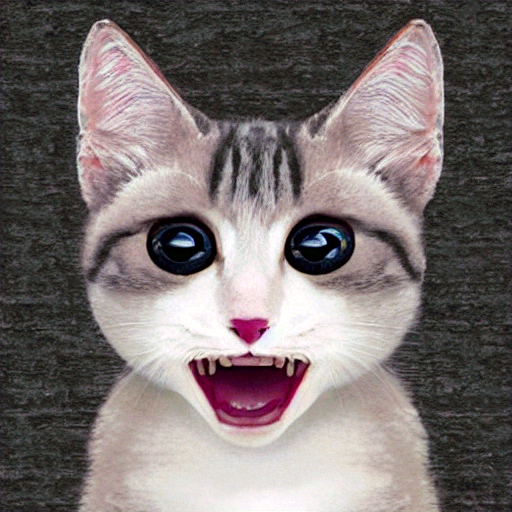

In [14]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

image = sessDecoder.run(None, {
    'input' : latents.detach().numpy()
})[0]
image = numpy_to_pil(image)
image[0].show()

In [41]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
timesteps
latents = latents0.clone()
extra_step_kwargs, ets = {}, []
for i, t in enumerate(timesteps):
    latent_model_input = torch.cat([latents] * 2).to(device = device)
    latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t).to(device = device)
    # predict the noise residual
    noise_pred = pipeline.unet(
        latent_model_input.to(device = device),
        t,
        encoder_hidden_states=torch.tensor(embed).to(device = device),
        cross_attention_kwargs=None,
        return_dict=False,
    )[0]
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
    # Scheduler step
    
    if t == 981:
        pipeline.scheduler.ets = [noise_pred]           # self.ets.append(model_output)
        pipeline.scheduler.cur_sample = latents
        
        noise_pred  = noise_pred.detach().numpy()
        latents     = latents.detach().numpy()
        latents     = sessScheduler981.run(None, {
            'model_output' : noise_pred,
            'sample'       : latents,  
        })[0]
        pipeline.scheduler.counter = 1
        latents     = torch.tensor(latents)
    elif t == 961 and i == 1:
        latents = sessScheduler9611.run(None, {
            'model_output'  : noise_pred.detach().numpy(),
            'cur_sample'    : pipeline.scheduler.cur_sample.detach().numpy(),
            'ets0'          : pipeline.scheduler.ets[-1].detach().numpy()
        })[0]
        pipeline.scheduler.counter = 2
        pipeline.scheduler.cur_sample = None
        latents     = torch.tensor(latents)
    elif t == 961 and i == 2: 
        latents = sessScheduler9612.run(None, {
            'model_output'  : noise_pred.detach().numpy(),
            'sample'        : latents.detach().numpy(),
            'ets0'          : pipeline.scheduler.ets[-1].detach().numpy()
        })[0]
        pipeline.scheduler.counter = 3
        pipeline.scheduler.ets.append(noise_pred)           # self.ets.append(model_output)
        latents     = torch.tensor(latents)
    elif t == 941:
        latents = sessScheduler941.run(None, {
            'model_output'  : noise_pred.detach().numpy(),
            'sample'        : latents.detach().numpy(),
            'ets0'          : pipeline.scheduler.ets[-1].detach().numpy(),
            'ets1'          : pipeline.scheduler.ets[-2].detach().numpy()
        })[0]
        pipeline.scheduler.counter = 4
        pipeline.scheduler.ets.append(noise_pred)           # self.ets.append(model_output)
        latents     = torch.tensor(latents)
    else:
        latents = schedulers[f'step-{t}.onnx'].run(None, {
            'noise_pred'    : noise_pred.detach().numpy(),
            'latents'       : latents.detach().numpy(),
            'ets1'          : pipeline.scheduler.ets[-1].detach().numpy(),        
            'ets2'          : pipeline.scheduler.ets[-2].detach().numpy(),
            'ets3'          : pipeline.scheduler.ets[-3].detach().numpy()
        })[0]
        pipeline.scheduler.counter = i + 1
        pipeline.scheduler.ets = pipeline.scheduler.ets[-3:]
        pipeline.scheduler.ets.append(noise_pred)
        latents     = torch.tensor(latents)

    print(t, end=' -> ' if (i%10 != 0 and i!= 0) else ' -> \n')

981 -> 
961 -> 961 -> 941 -> 921 -> 901 -> 881 -> 861 -> 841 -> 821 -> 801 -> 
781 -> 761 -> 741 -> 721 -> 701 -> 681 -> 661 -> 641 -> 621 -> 601 -> 
581 -> 561 -> 541 -> 521 -> 501 -> 481 -> 461 -> 441 -> 421 -> 401 -> 
381 -> 361 -> 341 -> 321 -> 301 -> 281 -> 261 -> 241 -> 221 -> 201 -> 
181 -> 161 -> 141 -> 121 -> 101 -> 81 -> 61 -> 41 -> 21 -> 1 -> 


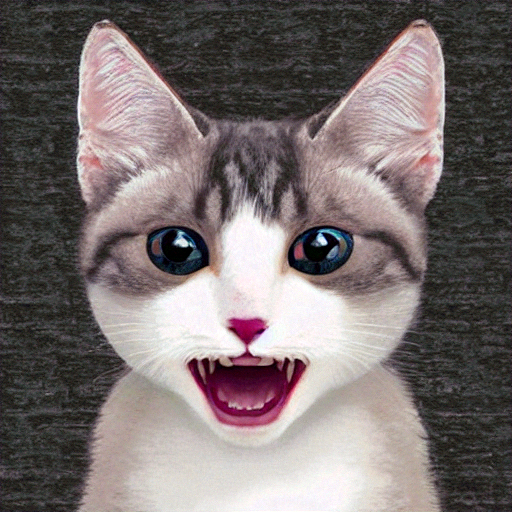

In [42]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

image = sessDecoder.run(None, {
    'input' : latents.detach().numpy()
})[0]
image = numpy_to_pil(image)
image[0].show()